<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-python-by-francois-chollet/7-deep-dive-into-keras/01_keras_model_fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Keras model fundamentals

There are three APIs for building models in Keras:

* The Sequential model, the most approachable API—it’s basically a Python list. As such, it’s limited to simple stacks of layers.
* The Functional API, which focuses on graph-like model architectures. It represents
a nice mid-point between usability and flexibility, and as such, it’s the
most commonly used model-building API.
* Model subclassing, a low-level option where you write everything yourself from
scratch. This is ideal if you want full control over every little thing. However, you
won’t get access to many built-in Keras features, and you will be more at risk of
making mistakes.

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-python-by-francois-chollet/7-deep-dive-into-keras/images/1.png?raw=1' width='600'/>

##Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import random
import string
import re

import numpy as np

##Sequential model

The simplest way to build a Keras model is to use the Sequential model.

In [2]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")                      
])

Note that it’s possible to build the same model incrementally via the `add()` method,
which is similar to the `append()` method of a Python list.

In [3]:
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

As such, the preceding Sequential model does not have any weights, until you actually call it on some data, or call its
method with an input shape `build()`.

In [4]:
# At that point, the model isn’t built yet
# model.weights

```log
ValueError: Weights for model sequential_1 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.
```

Builds the model—now the model will expect samples of shape (3,). The
None in the input shape signals that the batch size could be anything.

In [5]:
model.build(input_shape=(None, 3))
# Now you can retrieve the model’s weights
model.weights

[<tf.Variable 'dense_2/kernel:0' shape=(3, 64) dtype=float32, numpy=
 array([[-0.21056874, -0.12314808,  0.23423874, -0.02400807,  0.10857916,
          0.1970011 , -0.1485263 , -0.12418826,  0.0998418 , -0.00206509,
         -0.2538972 , -0.20668472,  0.06265518, -0.09482916,  0.09345835,
          0.23152119,  0.06565449,  0.03644684,  0.25797498,  0.23759824,
         -0.29416925,  0.0999693 ,  0.03616938,  0.18761641,  0.28119934,
         -0.09683216, -0.13382515,  0.18253055, -0.21043639,  0.02598289,
         -0.12579186, -0.09721772,  0.14684892,  0.14754769, -0.12935331,
         -0.17898145,  0.01912695, -0.04977247,  0.0581114 ,  0.03220195,
          0.26588362, -0.01979271, -0.20433027, -0.07501104, -0.00453761,
         -0.15279323, -0.05488822,  0.16248772, -0.12889576, -0.17337018,
          0.14957097,  0.14020106,  0.09207636,  0.20403427, -0.0133546 ,
         -0.27011508, -0.02674785,  0.0509285 , -0.17196642, -0.26655805,
         -0.09708993,  0.09202376, -0.26028

After the model is built, you can display its contents via the
method, which `summary()` comes in handy for debugging.

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


As you can see, this model happens to be named “sequential_1.” You can give names
to everything in Keras—every model, every layer.

In [7]:
model = keras.Sequential(name="my_example_model")
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))
model.add(layers.Dense(10, activation="softmax", name="my_last_layer"))

model.build((None, 3))
model.summary()

Model: "my_example_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_first_layer (Dense)      (None, 64)                256       
                                                                 
 my_last_layer (Dense)       (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


But you can’t print a summary until the model is built! 

There’s actually a way to have your Sequential
built on the fly: just declare the shape of the model’s inputs in advance. You can do this via the Input class.

In [8]:
model = keras.Sequential(name="my_example_model")
model.add(keras.Input(shape=(3, )))
model.add(layers.Dense(64, activation="relu", name="my_first_layer"))

Now you can use `summary()` to follow how the output shape of your model changes as
you add more layers

In [9]:
model.summary()

Model: "my_example_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_first_layer (Dense)      (None, 64)                256       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.add(layers.Dense(10, activation="softmax", name="my_last_layer"))

model.summary()

Model: "my_example_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_first_layer (Dense)      (None, 64)                256       
                                                                 
 my_last_layer (Dense)       (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


This is a pretty common debugging workflow when dealing with layers that transform
their inputs in complex ways, such as the convolutional layers.

##Functional API

The Sequential model is easy to use, but its applicability is extremely limited: it can
only express models with a single input and a single output, applying one layer after
the other in a sequential fashion.

Let’s start with something simple.

In [11]:
inputs = keras.Input(shape=(3, ), name="my_input")
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)

model = keras.Model(inputs=inputs, outputs=outputs)

This inputs object holds information about the shape and dtype of the data that the
model will process:

In [12]:
inputs.shape

TensorShape([None, 3])

In [13]:
inputs.dtype

tf.float32

We call such an object a symbolic tensor. It doesn’t contain any actual data, but it
encodes the specifications of the actual tensors of data that the model will see when
you use it. It stands for future tensors of data.

All Keras layers can be called both on real tensors of data and on these symbolic tensors.

In [14]:
features.shape

TensorShape([None, 64])

In [15]:
features.dtype

tf.float32

Here’s the summary of our model:

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_4 (Dense)             (None, 64)                256       
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


###Creating multi-input and multi-output

As you will see, most deep learning models don’t look like lists—they look like
graphs. They may, for instance, have multiple inputs or multiple outputs. It’s for this
kind of model that the Functional API really shines.

Let’s say you’re building a system to rank customer support tickets by priority and
route them to the appropriate department. Your model has three inputs:

* The title of the ticket (text input)
* The text body of the ticket (text input)
* Any tags added by the user (categorical input, assumed here to be one-hot
encoded)

Your model also has two outputs:
* The priority score of the ticket, a scalar between 0 and 1 (sigmoid output)
* The department that should handle the ticket (a softmax over the set of departments)

In [17]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

# Define model inputs
title = keras.Input(shape=(vocabulary_size, ), name="title")
text_body = keras.Input(shape=(vocabulary_size, ), name="text_body")
tags = keras.Input(shape=(num_tags, ), name="tags")

# Combine input features into a single tensor, features, by concatenating them.
features = layers.Concatenate()([title, text_body, tags])
# Apply an intermediate layer to recombine input features into richer representations
features = layers.Dense(64, activation="relu")(features)

# Define model outputs
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(features)

# Create the model by specifying its inputs and outputs
model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

The Functional API is a simple, LEGO-like, yet very flexible way to define arbitrary
graphs of layers like these.

###Training multi-input and multi-output

You can train your model in much the same way as you would train a Sequential
model, by calling `fit()` with lists of input and output data.

In [18]:
num_samples = 1280

# dummy input data
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

# dummy target data
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer="rmsprop", loss=["mean_squared_error", "categorical_crossentropy"], metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit([title_data, text_body_data, tags_data], [priority_data, department_data], epochs=1)

40/40 [==============================] - 2s 18ms/step - loss: 36.6169 - priority_loss: 0.3245 - department_loss: 36.2924 - priority_mean_absolute_error: 0.4922 - department_accuracy: 0.2180


In [20]:
model.evaluate([title_data, text_body_data, tags_data], [priority_data, department_data])

40/40 [==============================] - 1s 11ms/step - loss: 24.9259 - priority_loss: 0.3343 - department_loss: 24.5917 - priority_mean_absolute_error: 0.5014 - department_accuracy: 0.2336


[24.92593765258789,
 0.3342789113521576,
 24.591663360595703,
 0.501447856426239,
 0.23359374701976776]

In [21]:
priority_preds, department_preds = model.predict([title_data, text_body_data, tags_data])

In [22]:
priority_preds

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [23]:
department_preds

array([[6.2746610e-03, 9.9372536e-01, 1.8103205e-11, 2.1242440e-11],
       [1.3679593e-02, 9.8632044e-01, 2.6111837e-11, 4.1389243e-11],
       [2.6674797e-03, 9.9733257e-01, 3.5672062e-12, 2.7331439e-11],
       ...,
       [4.0120251e-02, 9.5987976e-01, 4.0027277e-11, 1.4289987e-10],
       [7.5983834e-03, 9.9240160e-01, 1.5337906e-11, 3.7643284e-11],
       [1.1326045e-01, 8.8673961e-01, 2.2551412e-11, 3.7989478e-10]],
      dtype=float32)

If you don’t want to rely on input order (for instance, because you have many inputs
or outputs), you can also leverage the names you gave to the Input objects and the
output layers, and pass data via dictionaries.

In [24]:
model.compile(optimizer="rmsprop", 
              loss={"priority": "mean_squared_error", "department": "categorical_crossentropy"}, 
              metrics={"priority": ["mean_absolute_error"], "department": ["accuracy"]})
model.fit({"title": title_data, "text_body": text_body_data, "tags": tags_data}, 
          {"priority": priority_data, "department": department_data}, epochs=1)
model.evaluate({"title": title_data, "text_body": text_body_data, "tags": tags_data}, 
          {"priority": priority_data, "department": department_data})

40/40 [==============================] - 0s 7ms/step - loss: 52.7017 - priority_loss: 0.3343 - department_loss: 52.3675 - priority_mean_absolute_error: 0.5014 - department_accuracy: 0.5836


[52.70172882080078,
 0.3342789113521576,
 52.36745071411133,
 0.501447856426239,
 0.5835937261581421]

In [25]:
priority_preds, department_preds = model.predict({"title": title_data, "text_body": text_body_data, "tags": tags_data})

In [26]:
priority_preds

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [27]:
department_preds

array([[9.9995863e-01, 4.8640212e-27, 3.5060881e-17, 4.1345491e-05],
       [9.9987733e-01, 3.6748446e-27, 2.3382207e-17, 1.2267377e-04],
       [9.9942857e-01, 3.2995605e-26, 3.5724720e-17, 5.7143008e-04],
       ...,
       [9.9998558e-01, 5.3297049e-28, 8.4343132e-18, 1.4450381e-05],
       [9.9986625e-01, 2.9190991e-27, 2.3901397e-17, 1.3368081e-04],
       [9.9997151e-01, 1.8391749e-28, 1.0110165e-18, 2.8479186e-05]],
      dtype=float32)

###The power of Functional API

A Functional model is an explicit graph data structure. This makes it possible to
inspect how layers are connected and reuse previous graph nodes (which are layer
outputs) as part of new models. It also nicely fits the “mental model” that most researchers
use when thinking about a deep neural network: a graph of layers. This enables
two important use cases: model visualization and feature extraction.

Let’s visualize the connectivity of the model we just defined (the topology of the
model).

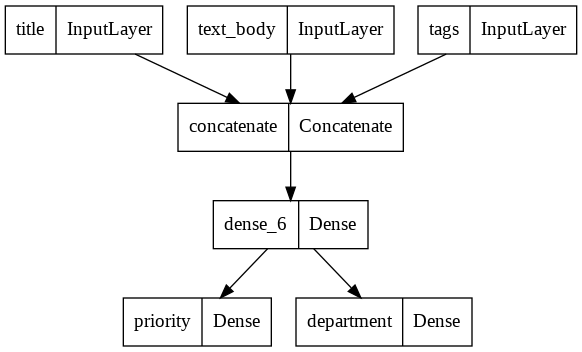

In [28]:
keras.utils.plot_model(model, "ticket_classifier.png")

You can add to this plot the input and output shapes of each layer in the model, which
can be helpful during debugging.

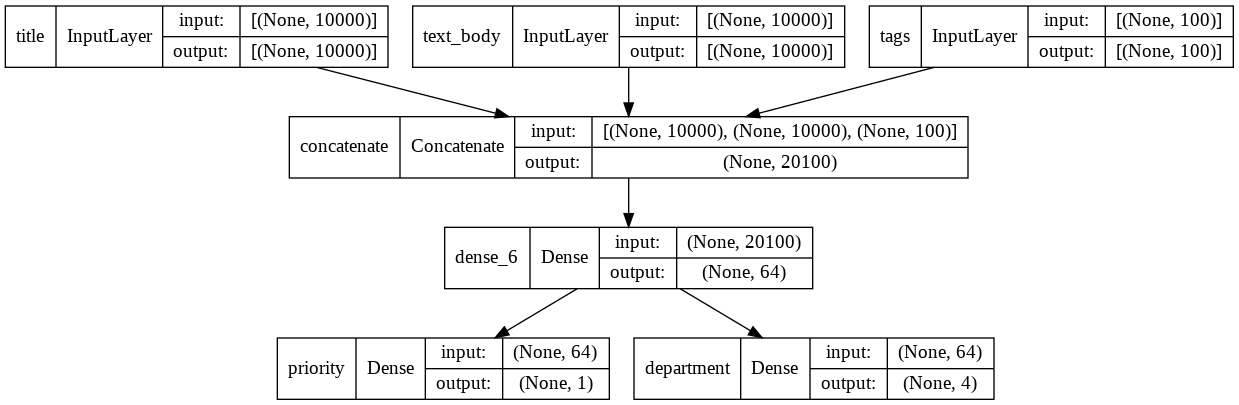

In [29]:
keras.utils.plot_model(model, "ticket_classifier_with_shape_info.png", show_shapes=True)

The “None” in the tensor shapes represents the batch size: this model allows batches
of any size.

Access to layer connectivity also means that you can inspect and reuse individual
nodes (layer calls) in the graph. 

The `model.layers` model property provides the list
of layers that make up the model, and for each layer you can query `layer.input` and `layer.output`.

In [30]:
model.layers

In [31]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [32]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

This enables you to do feature extraction, creating models that reuse intermediate features
from another model.

Let’s say you want to add another output to the previous model—you want to estimate
how long a given issue ticket will take to resolve, a kind of difficulty rating. 

You could do this via a classification layer over three categories: “quick,” “medium,” and “difficult.” 

You don’t need to recreate and retrain a model from scratch. You can start
from the intermediate features of your previous model, since you have access to them,
like this.

In [33]:
# layers[4] is our intermediate Dense layer
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)

new_model =  keras.Model(inputs=[title, text_body, tags], outputs=[priority, department, difficulty])

Let’s plot our new model.

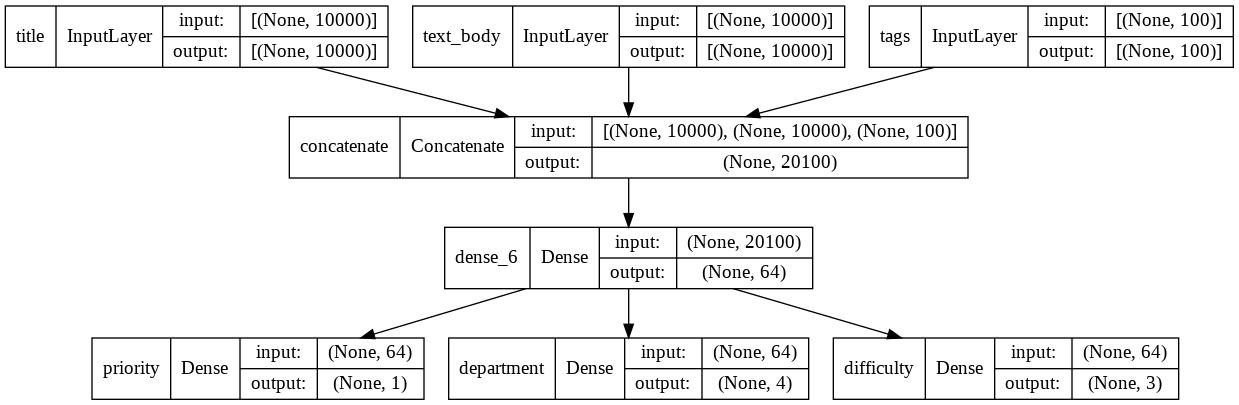

In [34]:
keras.utils.plot_model(new_model, "updated_ticket_classifier.png", show_shapes=True)

##Subclassing the Model class